In [1]:
!python --version

Python 3.10.15


In [2]:
#**Import Libraries :**
#@title Import and Install Libraries { vertical-output: true, display-mode: "form" }

import numpy as np
from numpy import vstack
from datasets import load_dataset
from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import (
    Compose,
    Normalize,
    ToTensor,
    Resize
)
import torch.optim as optim
from torch.optim import lr_scheduler

import tensorflow as tf
import os
import PIL
from PIL import Image
from fastervit import create_model
import time
import copy
import matplotlib.pyplot as plt
import seaborn as sbn

from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from transformers import AutoModelForImageClassification

np.random.seed(0)
torch.manual_seed(0)

print("All libraries are imported successfully")

/arf/sw/apps/truba-ai/cpu/miniforge3-2024/envs/cpu-2024.0/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/arf/sw/apps/truba-ai/cpu/miniforge3-2024/envs/cpu-2024.0/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2024-11-17 15:19:29.034141: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-17 15:19:29.109626: I tensorflow/core/platform/cpu_feat

All libraries are imported successfully


In [3]:
torch.__version__

'2.1.2+cu121'

In [15]:
# @title Defining Paths and Parameters
class Path :
  def __init__(self, choice) :
    name = choice # choice = "132+800" | choice = "50+150" | choice = "206+200"

    self.training_dataset = "/arf/home/edilek/KMO_Sample_Dataset/Training_dataset/" + name
    self.validation_dataset = "/arf/home/edilek/KMO_Sample_Dataset/Validation_dataset/" + name
    self.test_dataset = "/arf/home/edilek/KMO_Sample_Dataset/Test_dataset/" + name

    self.model_name = "FasterViT"
    self.model_path =  "/arf/home/edilek/ViT_FT_Output/Models/"+ name + "/" + self.model_name + ".pth"
    self.w_h = 224

print("Paths and Parameters are defined successfully")

Paths and Parameters are defined successfully


In [16]:
#@title Choice of Dataset and Parameters { display-mode: "form" }
choice = "132+800" #@param ["132+800", "50+150", "206+200"]
paths = Path(choice)

w_h               = paths.w_h
model_name        = paths.model_name
model_path        = paths.model_path
#print(model_path)

In [17]:
#@title Create Output Folders
def create_output_folders():
   
  if not os.path.exists("/arf/home/edilek/ViT_FT_Output/Images/" + choice + "/Confusion_Matrix/"): 
      os.makedirs("/arf/home/edilek/ViT_FT_Output/Images/" + choice + "/Confusion_Matrix/")
      
  if not os.path.exists("/arf/home/edilek/ViT_FT_Output/Images/" + choice + "/ROC/"):
      os.makedirs("/arf/home/edilek/ViT_FT_Output/Images/" + choice + "/ROC/")
      
  if not os.path.exists("/arf/home/edilek/ViT_FT_Output/Images/" + choice + "/Accuracy/"):
      os.makedirs("/arf/home/edilek/ViT_FT_Output/Images/" + choice + "/Accuracy/")
      
  if not os.path.exists("/arf/home/edilek/ViT_FT_Output/Images/" + choice + "/Loss/"): 
      os.makedirs("/arf/home/edilek/ViT_FT_Output/Images/" + choice + "/Loss/")

  if not os.path.exists("/arf/home/edilek/ViT_FT_Output/Models/" + choice +"/"): 
      os.makedirs("/arf/home/edilek/ViT_FT_Output/Models/" + choice + "/")

create_output_folders()

len train_set: 12733
len validation_set: 2547
len test_set: 638
dataset_sizes: [12733, 2547, 638]
Dataset ImageFolder
    Number of datapoints: 12733
    Root location: /arf/home/edilek/KMO_Sample_Dataset/Training_dataset/132+800
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
labels: ['Anomaly', 'Normal']
id2label: {0: 'Anomaly', 1: 'Normal'}
label2id: {'Anomaly': 0, 'Normal': 1}
example: (tensor([[[-1.9124, -1.7412, -1.9124,  ..., -1.8097, -1.9980, -1.7925],
         [-1.7240, -1.9638, -1.6555,  ..., -1.9124, -1.7754, -1.8953],
         [-1.7412,  0.6734, -1.2274,  ...,  2.1119,  0.7248, -1.6727],
         ...,
         [-0.0287, -0.0287, -0.0458,  ..., -0.7650, -0.8849, -0.7993],
         [-0.0287, -0.0287, -0.0458,  ..., -1.1589, -0.6109, -1.0048],
         [-0.0116, -0.0287, -0.0458,  ...,  1.6324, -1.0219, -0.8678]],

        [[-1.8256, -1.6506, -1.8256,  ..., -1.7206,

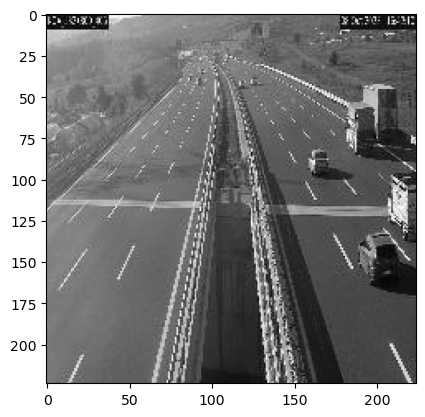

In [18]:
#@title Loading data
transform = transforms.Compose([  transforms.ToTensor(),
                                  transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
                                ])

train_set      = datasets.ImageFolder(paths.training_dataset, transform=transform)
validation_set = datasets.ImageFolder(paths.validation_dataset, transform=transform)
test_set       = datasets.ImageFolder(paths.test_dataset, transform=transform)
dataset_sizes  = [len(train_set), len(validation_set), len(test_set)]    

print("len train_set:", len(train_set))
print("len validation_set:", len(validation_set))
print("len test_set:", len(test_set)) 
print("dataset_sizes:", dataset_sizes)

train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
valid_loader = DataLoader(validation_set, shuffle=True, batch_size=128)
test_loader  = DataLoader(test_set, shuffle=False, batch_size=128)

print(train_set)
labels = ['Anomaly', 'Normal']
print("labels:", labels)

id2label = {k:v for k,v in enumerate(labels)}
label2id = {v:k for k,v in enumerate(labels)}

print("id2label:", id2label)
print("label2id:", label2id)

example = train_set[0]
print("example:", example)
plt.imshow(example[0].numpy()[0], cmap='gray') 

In [19]:
#@title Define the Model
# Load the FasterViT model and modify it for your number of classes.

from fastervit import create_model

# Load pre-trained FasterViT model
model = create_model('faster_vit_0_224', 
                     pretrained=True,
                     model_path="/arf/home/edilek/faster_vit_0.pth.tar")
# Print the model architecture
print(model)

FasterViT(
  (patch_embed): PatchEmbed(
    (proj): Identity()
    (conv_down): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (levels): ModuleList(
    (0): FasterViTLayer(
      (blocks): ModuleList(
        (0): ConvBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): GELU(approximate='none')
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [20]:
# Modify the final layer for custom classification
num_ftrs = model.head.in_features
model.head = torch.nn.Linear(num_ftrs, len(labels))

In [21]:
# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

model = model.to(device)

In [23]:
# Defining training options
N_EPOCHS = 3
LR = 0.001

# Define loss function
criterion = torch.nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)

# Learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [24]:
def main():
    # Training loop
    train_acc_values, val_acc_values, train_loss_values, val_loss_values = list(), list(), list(), list()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_time = 0.0
    valid_time = 0.0
    test_time = 0.0
    
    for epoch in trange(N_EPOCHS, desc="Training"):
        ###########################################################################
        print("Training epoch:", epoch+1)
        t0 = time.time()
        
        model.train(True)

        train_accuracy = 0.0    
        train_loss = 0.0
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
            #print("batch.shape:", batch[0].shape)
            x, y = batch            
            x, y = x.to(device), y.to(device)

            # Zero your gradients for every batch!
            optimizer.zero_grad()

            # Make predictions for this batch
            y_hat = model(x)

            #print("x.shape:", x.shape, " y.shape:", y.shape, "y_hat shape :", y_hat.shape)
            # Compute the loss and its gradients
            loss = criterion(y_hat, y)  
            loss.backward()

            # Adjust learning weights
            optimizer.step()
            
            train_loss += loss.detach().cpu().item() / len(train_loader)

            acc = (y_hat.argmax(dim=1) == y).float().mean()
            train_accuracy += acc / len(train_loader)
            
        t1 = round(time.time() - t0)
        train_time = train_time + t1
        ###########################################################################
        
        print("Validating epoch:", epoch+1)
        # Set the model to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.
        t0 = time.time()
        
        model.eval()

        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            val_accuracy = 0.0
            val_loss = 0.0
            
            for batch in tqdm(valid_loader, desc="Validating"):
                x, y = batch
                x, y = x.to(device), y.to(device)
                y_hat = model(x)
                
                loss = criterion(y_hat, y)            
                val_loss += loss.detach().cpu().item() / len(valid_loader)

                acc = (y_hat.argmax(dim=1) == y).float().mean()
                val_accuracy += acc / len(valid_loader)

        t1 = round(time.time() - t0)
        valid_time = valid_time + t1
        ###########################################################################
        # Store train/validation acc/loss history 
        
        train_acc_values.append(torch.round(train_accuracy, decimals=4))
        val_acc_values.append(torch.round(val_accuracy, decimals=4))
        
        train_loss_values.append(torch.round(torch.as_tensor(train_loss), decimals=4))
        val_loss_values.append(torch.round(torch.as_tensor(val_loss), decimals=4))

        # Deep copy the model
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
                
        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.4f} best_acc: {best_acc:.4f}")
        print(f"Epoch : {epoch+1} - loss : {train_loss:.4f} - acc: {train_accuracy:.4f} - val_loss : {val_loss:.4f} - val_acc: {val_accuracy:.4f}\n")
        ###########################################################################

    # Save the model's state
    torch.save(best_model_wts, model_path)

    #############################################################################
    # Draw Training/Validation Accuracy Graph
    acc     = train_acc_values
    val_acc = val_acc_values
    
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(10, 10))
    plt.plot(torch.stack(train_acc_values).cpu().numpy(), label='Training Accuracy')  
    plt.plot(torch.stack(val_acc_values).cpu().numpy(), label='Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.ylim([0, 1])
    plt.legend(loc='lower left')
    plt.title(model_name)
    plt.savefig(("/arf/home/edilek/ViT_FT_Output/Images/" + choice + "/Accuracy/"+ model_name +'.jpg'), bbox_inches='tight', transparent=True, dpi=300)
    plt.show()

    # Draw Training/Validation Loss Graph
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(10, 10))
    plt.plot(torch.stack(train_loss_values).cpu().numpy(), label='Training Loss')
    plt.plot(torch.stack(val_loss_values).cpu().numpy(), label='Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.ylim([0, 1])
    plt.legend(loc='lower left')
    plt.title(model_name)
    plt.savefig(("/arf/home/edilek/ViT_FT_Output/Images/" + choice + "/Loss/"+ model_name +'.jpg'), bbox_inches='tight', transparent=True, dpi=300)
    plt.show()
    ###############################################################################

    # Test loop
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        predictions, actuals = list(), list()
        
        for batch in tqdm(test_loader, desc="Testing"):
            t0 = time.time()
            
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)

            t1 = round(time.time() - t0)
            test_time = test_time + t1
            
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(test_loader)
            
            # tahmin edilen sinif = en yuksek degere sahip sutun indeksi
            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item() 
            total += len(x)

            #print("x.shape:", x.shape, "y.shape:", y.shape, " y_hat.shape:", y_hat.shape)
            #print("y[0]:", y[0], " y_hat[0,0]:", y_hat[0,0], " y_hat[0,1]:", y_hat[0,1])
            
            ############ Calculate accuracy in a different way ###########
            
            #print("yhat shape1:", y_hat.shape)
            # retrieve numpy array
            y_hat = y_hat.detach().cpu().numpy()
            #print("yhat shape2:", y_hat.shape)
            
            actual = y.detach().cpu().numpy()
            actual = actual.reshape((len(actual), 1))                       
            
            # store y_hat and actual values
            p = np.argmax(y_hat, axis=1).reshape((len(y_hat), 1)) # tahmin edilen sinif = en yuksek degere sahip sutun indeksi
            #print("actual[0]:", actual[0], " y_hat[0,0]:", y_hat[0,0], " y_hat[0,1]:", y_hat[0,1])            
            predictions.append(p) 
            actuals.append(actual)    
            #print("actual.shape:", actual.shape, " y_hat.shape:", y_hat.shape, " prediction.shape:", p.shape)
            #print("actual:", actual," prediction:", p)
            ###########################################################
        
        print(f"Test loss: {test_loss:.4f} Test accuracy: {correct / total * 100:.2f}%")
        #print(f"Test accuracy: {correct / total * 100:.2f}%")

        ############ Calculate accuracy in a different way ###########
        predictions, actuals = vstack(predictions), vstack(actuals)
        acc = metrics.accuracy_score(actuals, predictions)         
        print(f"Test accuracy 2: {acc * 100:.2f}%")

        print("actuals.shape:", actuals.shape, " predictions.shape:", predictions.shape)
        actuals = tf.squeeze(actuals)
        predictions = tf.squeeze(predictions)
        #########################################################################################################
        print("\n")
        print(f"Training time: {train_time:.4f}s Validation time: {valid_time:.4f}s Test time: {test_time:.4f}s")
        print(f"Training time of a frame: {(train_time/dataset_sizes[0]):.4f}s")
        print(f"Validation time of a frame: {(valid_time/dataset_sizes[1]):.4f}s")
        print(f"Prediction time of a frame: {(test_time/dataset_sizes[2]):.4f}s")
        if test_time > 0 :
            fps = round(dataset_sizes[2]/test_time)
            print(f"fps: {fps}")

        # Calculation of Metrics
        # Accuracy = metrics.accuracy_score(actual, predicted)
        # Precision = metrics.precision_score(actual, predicted)
        # Sensitivity_recall = metrics.recall_score(actual, predicted)
        # Specificity = metrics.recall_score(actual, predicted, pos_label=0)
        # F1_score = metrics.f1_score(actual, predicted)

        #############################################################################
        # Create Confusion Matrix

        TP, FN, FP, TN = confusion_matrix(actuals, predictions).ravel()

        print('\n')
        print('True Positive(TP)  = ', TP)
        print('False Positive(FP) = ', FP)
        print('True Negative(TN)  = ', TN)
        print('False Negative(FN) = ', FN)
        accuracy =  (TP + TN) / (TP + FP + TN + FN)
        precision = TP/(TP + FP)
        recall = TP / (TP + FN)
        F1_score = (2 * precision * recall)/(precision + recall)
        print('Accuracy = {:0.4f}'.format(accuracy), ' Precision = {:0.4f}'.format(precision), ' Recall = {:0.4f}'.format(recall), ' F1 Score = {:0.4f}'.format(F1_score))
        print('\n')  

        cm = tf.math.confusion_matrix(actuals, predictions)
        cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]
        plt.figure(figsize=(10, 7))
        sbn.set(font_scale=1.6)
        sbn.heatmap(cm,cmap="YlGnBu",cbar=False, xticklabels=['Anomaly','Normal'], yticklabels=['Anomaly','Normal'], annot=True, fmt='.4f')
        plt.title(model_name)
        plt.xlabel('Predicted',labelpad=10)
        plt.ylabel('Actual',labelpad=10)
        plt.savefig(("/arf/home/edilek/ViT_FT_Output/Images/" + choice + "/Confusion_Matrix/"+ model_name +'.jpg'), bbox_inches='tight', transparent=True, dpi=300)
        plt.show()
        #############################################################################

        #############################################################################
        # Create Classification Report
        from sklearn.metrics import classification_report
        target_names = ['Anomaly','Normal']
        print(classification_report(actuals, predictions, target_names=target_names))
        #############################################################################

        #############################################################################
        # Draw ROC Curve
        fpr,tpr,thresholds = metrics.roc_curve(actuals, predictions)
        auc = metrics.roc_auc_score(actuals, predictions)
        print("AUC = {:0.4f}".format(auc))
        plt.figure(figsize=(10, 7))
        plt.title("Camera No:"+ choice +" ROC Curve")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.plot(fpr,tpr, label='ROC curve of '+ model_name.upper() +' (AUC = '+  "{:.4f}".format(auc)+')')
        plt.legend(fontsize="xx-small", bbox_to_anchor =(1.0, 0.07), loc='lower right')
        plt.axhline(0, color="black", alpha=0.3)
        plt.axvline(0, color="black", alpha=0.3)
        plt.savefig(("/arf/home/edilek/ViT_FT_Output/Images/" + choice + "/ROC/"+ model_name +'.jpg'), bbox_inches='tight', transparent=True, dpi=300)
        plt.show()
        #############################################################################                      

In [25]:
main()

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training epoch: 1



Training:   0%|          | 0/3 [03:01<?, ?it/s]                      


KeyboardInterrupt: 